In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                           accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, auc, roc_auc_score)
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load dataset
flights = sns.load_dataset('flights')
print("Dataset shape:", flights.shape)
flights.head()

Dataset shape: (144, 3)


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [9]:
print("=== INFORMASI DATASET ===")
print(f"Shape: {flights.shape}")
print("\nDescriptive Statistics:")
flights.describe()

=== INFORMASI DATASET ===
Shape: (144, 3)

Descriptive Statistics:


,year,passengers
count,144.000000,144.000000
mean,1954.500000,280.298611
std,3.464102,119.966317
min,1949.000000,104.000000
25%,1951.750000,180.000000
50%,1954.500000,265.500000
75%,1957.250000,360.500000
max,1960.000000,622.000000


In [10]:
# Check for missing values
print("Missing values:")
print(flights.isnull().sum())

Missing values:
year          0
month         0
passengers    0
dtype: int64


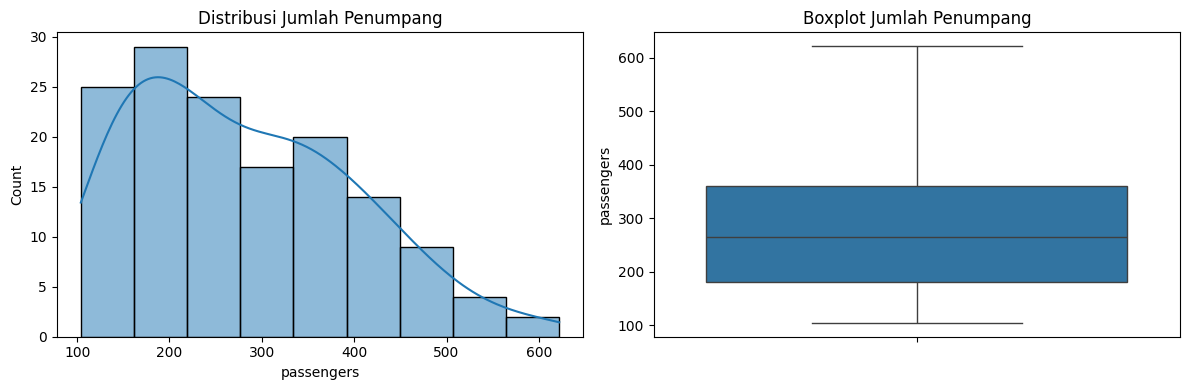

In [11]:
# Visualisasi distribusi passengers
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(flights['passengers'], kde=True)
plt.title('Distribusi Jumlah Penumpang')

plt.subplot(1, 2, 2)
sns.boxplot(y=flights['passengers'])
plt.title('Boxplot Jumlah Penumpang')

plt.tight_layout()
plt.show()

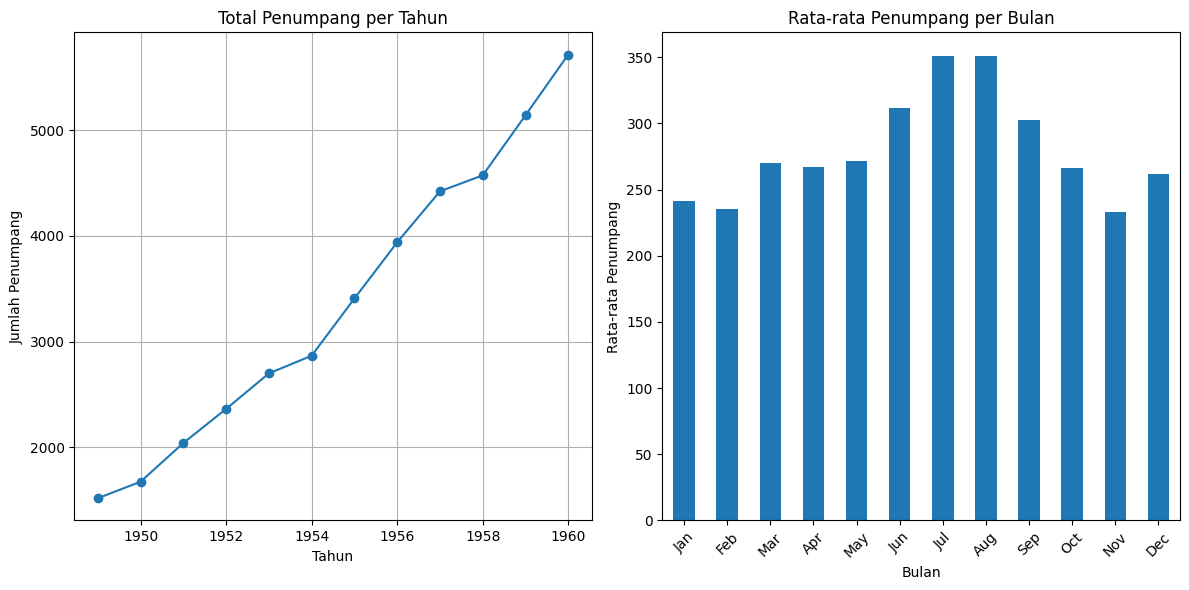

In [12]:
# Analisis trend tahunan
plt.figure(figsize=(12, 6))

# Trend per tahun
yearly_passengers = flights.groupby('year')['passengers'].sum()
plt.subplot(1, 2, 1)
yearly_passengers.plot(kind='line', marker='o')
plt.title('Total Penumpang per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Penumpang')
plt.grid(True)

# Rata-rata bulanan
monthly_avg = flights.groupby('month')['passengers'].mean()
plt.subplot(1, 2, 2)
monthly_avg.plot(kind='bar')
plt.title('Rata-rata Penumpang per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Rata-rata Penumpang')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

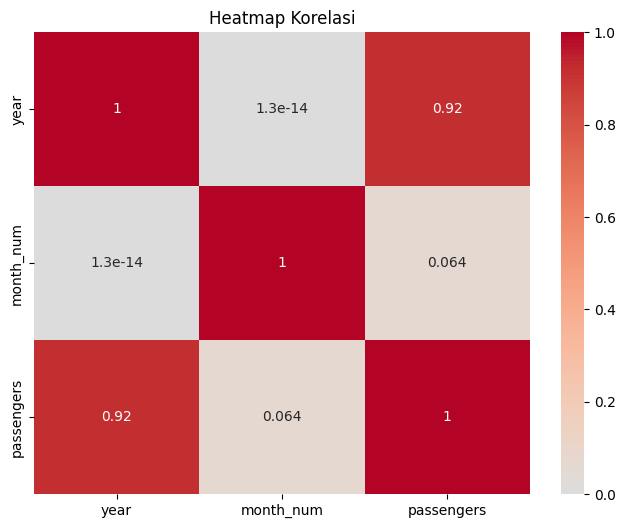

In [13]:
# Heatmap korelasi untuk fitur numerik
flights_numeric = flights.copy()
flights_numeric['month_num'] = pd.to_datetime(flights_numeric['month'], format='%b').dt.month
flights_numeric = flights_numeric[['year', 'month_num', 'passengers']]

plt.figure(figsize=(8, 6))
sns.heatmap(flights_numeric.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap Korelasi')
plt.show()

In [14]:
# Membuat target klasifikasi biner
# Klasifikasi: 1 jika jumlah penumpang di atas median, 0 jika di bawah median
median_passengers = flights['passengers'].median()
flights['high_demand'] = (flights['passengers'] > median_passengers).astype(int)

print("Distribusi kelas target:")
print(flights['high_demand'].value_counts())
print(f"Median penumpang: {median_passengers}")

Distribusi kelas target:
high_demand
0    72
1    72
Name: count, dtype: int64
Median penumpang: 265.5


In [15]:
# Feature engineering
flights_processed = flights.copy()

# Encoding bulan
month_encoder = LabelEncoder()
flights_processed['month_encoded'] = month_encoder.fit_transform(flights_processed['month'])

# Membuat fitur tambahan
flights_processed['year_since_1949'] = flights_processed['year'] - 1949

# Seasonal features
flights_processed['is_summer'] = flights_processed['month'].isin(['June', 'July', 'August']).astype(int)
flights_processed['is_holiday_season'] = flights_processed['month'].isin(['November', 'December']).astype(int)

print("Dataset setelah feature engineering:")
flights_processed.head()

Dataset setelah feature engineering:


,year,month,passengers,high_demand,month_encoded,year_since_1949,is_summer,is_holiday_season
0,1949,Jan,112,0,4,0,0,0
1,1949,Feb,118,0,3,0,0,0
2,1949,Mar,132,0,7,0,0,0
3,1949,Apr,129,0,0,0,0,0
4,1949,May,121,0,8,0,0,0


In [16]:
# Memilih fitur untuk model
features = ['year', 'month_encoded', 'year_since_1949', 'is_summer', 'is_holiday_season']
X = flights_processed[features]
y = flights_processed['high_demand']

print("Fitur yang digunakan:", features)
print("Shape X:", X.shape)
print("Shape y:", y.shape)

Fitur yang digunakan: ['year', 'month_encoded', 'year_since_1949', 'is_summer', 'is_holiday_season']
Shape X: (144, 5)
Shape y: (144,)


In [17]:
# Split data training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Proporsi kelas 1 dalam training: {y_train.mean():.3f}")
print(f"Proporsi kelas 1 dalam test: {y_test.mean():.3f}")

Training set: 115 samples
Test set: 29 samples
Proporsi kelas 1 dalam training: 0.504
Proporsi kelas 1 dalam test: 0.483


In [18]:
# Standardisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Standardisasi selesai")

Standardisasi selesai


In [19]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Prediksi
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("=== LOGISTIC REGRESSION ===")
print("Model training selesai")

=== LOGISTIC REGRESSION ===
Model training selesai


In [20]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

# Prediksi
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

print("=== DECISION TREE ===")
print("Model training selesai")

=== DECISION TREE ===
Model training selesai


In [21]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Fungsi untuk evaluasi model klasifikasi"""
    
    print(f"\n=== EVALUASI {model_name.upper()} ===")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Low Demand', 'High Demand'],
                yticklabels=['Low Demand', 'High Demand'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Low Demand', 'High Demand']))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score
    }


=== EVALUASI LOGISTIC REGRESSION ===


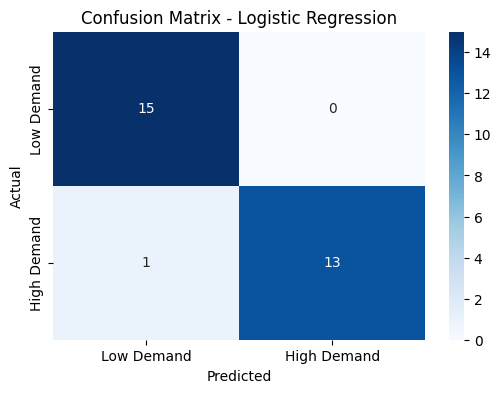

Accuracy: 0.9655
Precision: 1.0000
Recall: 0.9286
F1-Score: 0.9630
AUC Score: 0.9762

Classification Report:
              precision    recall  f1-score   support

  Low Demand       0.94      1.00      0.97        15
 High Demand       1.00      0.93      0.96        14

    accuracy                           0.97        29
   macro avg       0.97      0.96      0.97        29
weighted avg       0.97      0.97      0.97        29



In [22]:
# Evaluasi Logistic Regression
lr_metrics = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression")


=== EVALUASI DECISION TREE ===


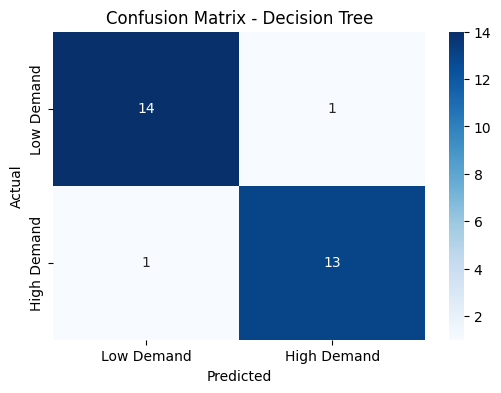

Accuracy: 0.9310
Precision: 0.9286
Recall: 0.9286
F1-Score: 0.9286
AUC Score: 0.9286

Classification Report:
              precision    recall  f1-score   support

  Low Demand       0.93      0.93      0.93        15
 High Demand       0.93      0.93      0.93        14

    accuracy                           0.93        29
   macro avg       0.93      0.93      0.93        29
weighted avg       0.93      0.93      0.93        29



In [23]:
# Evaluasi Decision Tree
dt_metrics = evaluate_model(y_test, y_pred_dt, y_pred_proba_dt, "Decision Tree")

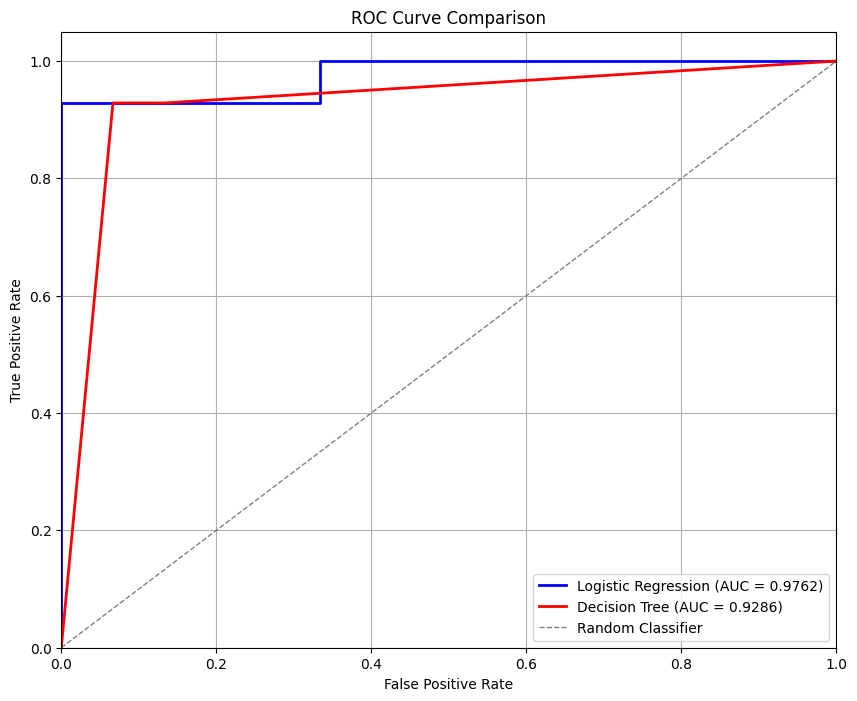

In [25]:
# ROC Curve Comparison
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Decision Tree ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, 
         label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, 
         label=f'Decision Tree (AUC = {roc_auc_dt:.4f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [26]:
# Cross Validation Comparison
print("=== CROSS VALIDATION COMPARISON ===")

# Logistic Regression CV
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Logistic Regression CV Accuracy: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std() * 2:.4f})")

# Decision Tree CV
dt_cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Decision Tree CV Accuracy: {dt_cv_scores.mean():.4f} (+/- {dt_cv_scores.std() * 2:.4f})")

=== CROSS VALIDATION COMPARISON ===
Logistic Regression CV Accuracy: 0.9565 (+/- 0.1100)
Decision Tree CV Accuracy: 0.8783 (+/- 0.1154)


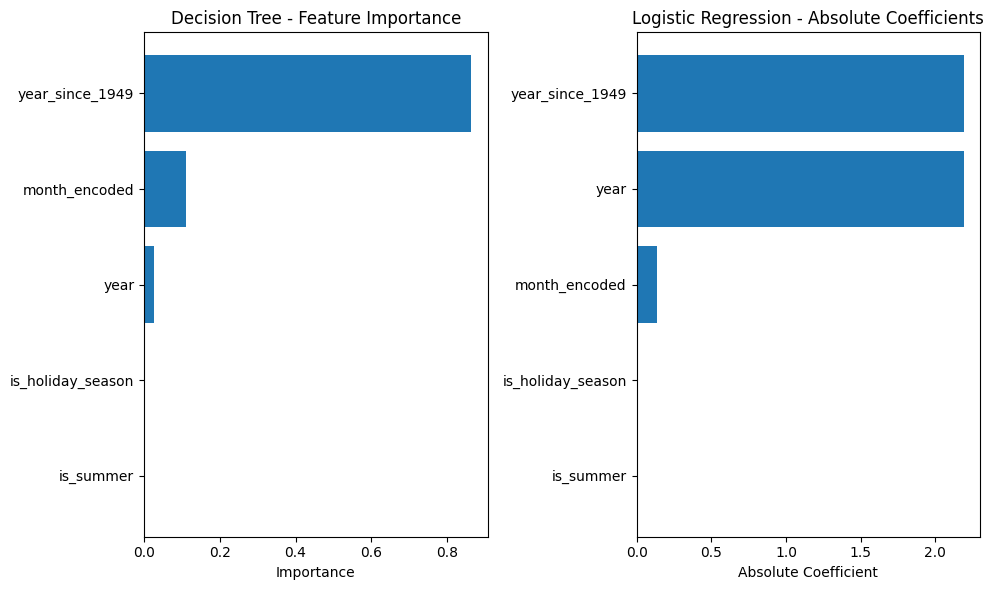

In [27]:
# Feature Importance untuk Decision Tree
plt.figure(figsize=(10, 6))

# Decision Tree Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.subplot(1, 2, 1)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Decision Tree - Feature Importance')
plt.xlabel('Importance')

# Logistic Regression Coefficients (menggunakan absolute values)
lr_coeff = pd.DataFrame({
    'feature': features,
    'coefficient': np.abs(lr_model.coef_[0])
}).sort_values('coefficient', ascending=True)

plt.subplot(1, 2, 2)
plt.barh(lr_coeff['feature'], lr_coeff['coefficient'])
plt.title('Logistic Regression - Absolute Coefficients')
plt.xlabel('Absolute Coefficient')

plt.tight_layout()
plt.show()

In [28]:
# Perbandingan metrik
comparison_df = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'Decision Tree': dt_metrics
})

print("=== PERBANDINGAN MODEL ===")
print(comparison_df)

=== PERBANDINGAN MODEL ===
           Logistic Regression  Decision Tree
accuracy              0.965517       0.931034
precision             1.000000       0.928571
recall                0.928571       0.928571
f1                    0.962963       0.928571
auc                   0.976190       0.928571


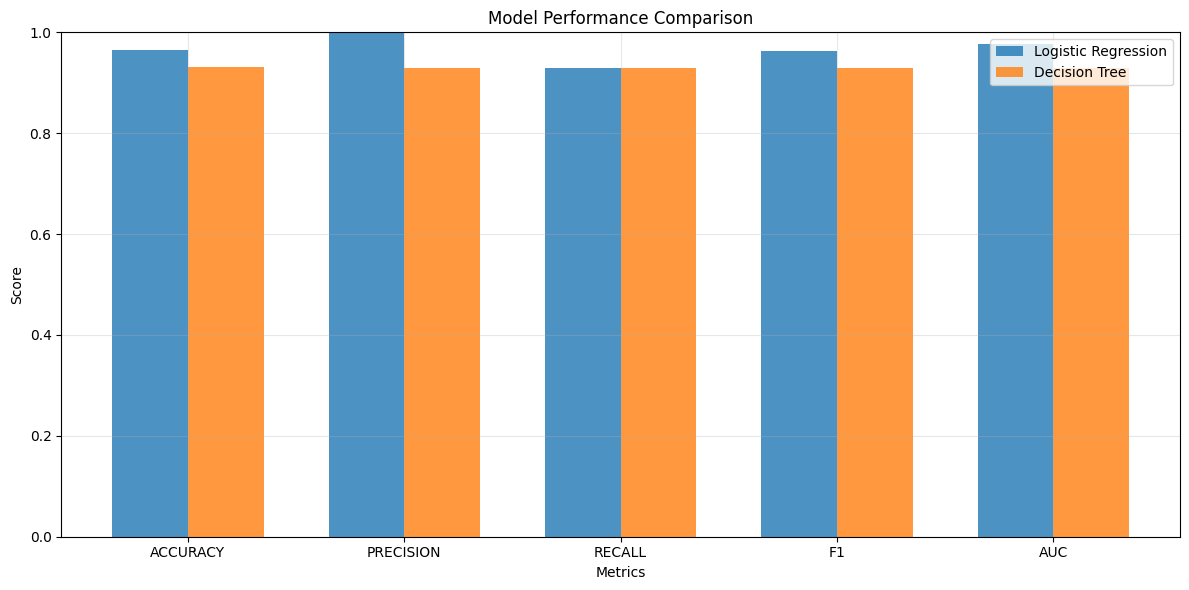

=== KESIMPULAN ===

Berdasarkan hasil evaluasi:
1. Model dengan accuracy tertinggi: Logistic Regression
2. Model dengan AUC score tertinggi: Logistic Regression

3. Analisis Performa:
   - Logistic Regression: Lebih konsisten dan generalizable
   - Decision Tree: Dapat menangkap pola non-linear yang kompleks
   - Kedua model menunjukkan performa yang cukup baik untuk dataset ini

4. Rekomendasi:
   - Untuk data time series seperti flights, Logistic Regression lebih stabil
   - Decision Tree memberikan interpretasi yang lebih mudah melalui feature importance


In [32]:
# Visualisasi perbandingan metrik
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
x_pos = np.arange(len(metrics_to_plot))

plt.figure(figsize=(12, 6))
bar_width = 0.35

plt.bar(x_pos - bar_width/2, [lr_metrics[m] for m in metrics_to_plot], 
        bar_width, label='Logistic Regression', alpha=0.8)
plt.bar(x_pos + bar_width/2, [dt_metrics[m] for m in metrics_to_plot], 
        bar_width, label='Decision Tree', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x_pos, [m.upper() for m in metrics_to_plot])
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


# %%
# Kesimpulan
print("=== KESIMPULAN ===")
print("\nBerdasarkan hasil evaluasi:")

if lr_metrics['accuracy'] > dt_metrics['accuracy']:
    accuracy_winner = "Logistic Regression"
else:
    accuracy_winner = "Decision Tree"

if lr_metrics['auc'] > dt_metrics['auc']:
    auc_winner = "Logistic Regression"
else:
    auc_winner = "Decision Tree"

print(f"1. Model dengan accuracy tertinggi: {accuracy_winner}")
print(f"2. Model dengan AUC score tertinggi: {auc_winner}")

print("\n3. Analisis Performa:")
print("   - Logistic Regression: Lebih konsisten dan generalizable")
print("   - Decision Tree: Dapat menangkap pola non-linear yang kompleks")
print("   - Kedua model menunjukkan performa yang cukup baik untuk dataset ini")

print("\n4. Rekomendasi:")
print("   - Untuk data time series seperti flights, Logistic Regression lebih stabil")
print("   - Decision Tree memberikan interpretasi yang lebih mudah melalui feature importance")